# Compreendendo a Arquitetura ALEX-NET
A arquitetura de rede neural convolucional (CNN) conhecida como AlexNet foi criada por Alex Krizhevsky, Ilya Sutskever e Geoffrey Hinton, que atuou como orientador de doutorado de Krizhevsky.

Esta foi a primeira arquitetura que usou GPU para aumentar o desempenho do treinamento. O AlexNet consiste em 5 camadas de convolução, 3 camadas de agrupamento máximo, 2 camadas normalizadas, 2 camadas totalmente conectadas e 1 camada SoftMax. Cada camada de convolução consiste em um filtro de convolução e uma função de ativação não linear chamada "ReLU". As camadas de pooling são usadas para executar a função max-pooling e o tamanho de entrada é fixo devido à presença de camadas totalmente conectadas. O tamanho da entrada é mencionado na maioria dos lugares como 224x224x3, mas devido a algum preenchimento que acontece, ele funciona para ser 227x227x3. Acima de tudo, o AlexNet tem mais de 60 milhões de parâmetros.

# Instalação de Pacotes

In [4]:
%pip install numpy
%pip install matplotlib
%pip install torch
%pip install torchvision
%pip install utils2
%pip install opencv-python
%pip install labelme

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Importe os módulos necessários

In [18]:
# Bibliotecas
import os
import os.path as osp
import shutil

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torchvision.models as models

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

import json
import labelme
import glob


# Declaração de Variáveis

In [31]:
import os
import shutil

# CUDA:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Verifica permissões em Pastas
def check_permissions(directory):
    if os.access(directory, os.W_OK):
        print(f"Permissão de escrita concedida para {directory}")
    else:
        print(f"Permissão de escrita negada para {directory}")
        return False
    return True

# Caminho do diretório Dataset:
directory = os.path.abspath(os.path.join(os.getcwd(), '..')) + r'\Dataset\nematode-detection-labels'
print(f'Diretório do Projeto {directory}.')
if not os.path.exists(directory):
    os.makedirs(directory)

img_folder_val = directory + r'\Val'
img_folder_val_mask = directory + r'\Val\Masks'
img_folder_train = directory + r'\Train'
img_folder_train_mask = directory + r'\Train\Masks'
img_folder_test = directory + r'\Test'
img_folder_test_mask = directory + r'\Test\Masks'
save_dir = directory + r'\\result_alexnet\\'

if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)
    
# Local onde o Modelo será salvo
model_file_name = save_dir + 'model_alexnet.pth'

# Organiza a estrutura de diretórios
def organize_files_in_folder(in_folder):
    image_dir = os.path.join(in_folder, "images")
    annotation_dir = os.path.join(in_folder, "annotations")
    mask_dir = os.path.join(in_folder, "masks")

    # Certifique-se de que o diretório de anotações existe
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(annotation_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    # Verifique as permissões dos diretórios
    if not (check_permissions(image_dir) and check_permissions(annotation_dir) and check_permissions(mask_dir)):
        raise PermissionError("Permissões insuficientes para um ou mais diretórios.")

    # Mover os arquivos
    for file_name in os.listdir(in_folder):
        # Mover o arquivo PNG para o diretório de anotações
        if file_name.endswith("_mask.png"):
            old_path = os.path.join(in_folder, file_name)
            new_path = os.path.join(mask_dir, file_name)
            shutil.move(old_path, new_path)
            print(f"Movido: {old_path} -> {new_path}")
        # Mover o arquivo JSON para o diretório de anotações
        if file_name.endswith(".json"):
            old_path = os.path.join(in_folder, file_name)
            new_path = os.path.join(annotation_dir, file_name)
            shutil.move(old_path, new_path)
            print(f"Movido: {old_path} -> {new_path}")
        # Mover o arquivo PNG para o diretório de anotações
        if file_name.endswith(".png"):
            old_path = os.path.join(in_folder, file_name)
            new_path = os.path.join(image_dir, file_name)
            shutil.move(old_path, new_path)
            print(f"Movido: {old_path} -> {new_path}")

organize_files_in_folder(directory + r"/Train")
organize_files_in_folder(directory + r"/Val")
organize_files_in_folder(directory + r"/Test")


resolution_input = (224, 224)  # Width x Height

patience = 30
plot_val = True
plot_train = True

max_epochs = 100

# Definindo as transformações para as imagens de entrada e máscaras
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

Diretório do Projeto c:\git\image-segmentation\Dataset\nematode-detection-labels.
Permissão de escrita concedida para c:\git\image-segmentation\Dataset\nematode-detection-labels/Train\images
Permissão de escrita concedida para c:\git\image-segmentation\Dataset\nematode-detection-labels/Train\annotations
Permissão de escrita concedida para c:\git\image-segmentation\Dataset\nematode-detection-labels/Train\masks
Permissão de escrita concedida para c:\git\image-segmentation\Dataset\nematode-detection-labels/Val\images
Permissão de escrita concedida para c:\git\image-segmentation\Dataset\nematode-detection-labels/Val\annotations
Permissão de escrita concedida para c:\git\image-segmentation\Dataset\nematode-detection-labels/Val\masks
Permissão de escrita concedida para c:\git\image-segmentation\Dataset\nematode-detection-labels/Test\images
Permissão de escrita concedida para c:\git\image-segmentation\Dataset\nematode-detection-labels/Test\annotations
Permissão de escrita concedida para c:\gi

# Converter Anotaão em JSON para Imagem com Mascaras

In [27]:
# Função para converter JSON em máscara PNG
def json_to_mask(json_file, output_path):
    # Carregar o JSON do Labelme
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Carregar a imagem de fundo para obter o tamanho correto
    image_data = labelme.utils.img_b64_to_arr(data['imageData'])
    height, width = image_data.shape[:2]

    # Criar uma máscara em branco (fundo = 0)
    mask = np.zeros((height, width), dtype=np.uint8)

    # Para cada anotação de polígono no JSON
    for shape in data['shapes']:
        points = shape['points']
        label = shape['label']

        # Escolher um valor para a classe (ajuste conforme necessário)
        class_value = 1 if label == "object" else 0

        # Criar um polígono na máscara
        mask = labelme.utils.shape_to_mask((height, width), points, shape_type=shape['shape_type'])
        mask[mask == True] = class_value

    # Salvar a máscara como imagem PNG
    mask_img = Image.fromarray(mask)
    mask_img.save(output_path)

# Aplicar a função para todos os arquivos JSON na pasta de entrada
for json_file in glob.glob(os.path.join(img_folder_train, '*.json')):
    file_name = os.path.splitext(os.path.basename(json_file))[0]
    output_path = os.path.join(img_folder_train_mask, f"{file_name}_mask.png")
    json_to_mask(json_file, output_path)

print("Conversão concluída! Máscaras PNG salvas em:", img_folder_train_mask)

# Aplicar a função para todos os arquivos JSON na pasta de entrada
for json_file in glob.glob(os.path.join(img_folder_val, '*.json')):
    file_name = os.path.splitext(os.path.basename(json_file))[0]
    output_path = os.path.join(img_folder_val_mask, f"{file_name}_mask.png")
    json_to_mask(json_file, output_path)

print("Conversão concluída! Máscaras PNG salvas em:", img_folder_val_mask)

# Aplicar a função para todos os arquivos JSON na pasta de entrada
for json_file in glob.glob(os.path.join(img_folder_test, '*.json')):
    file_name = os.path.splitext(os.path.basename(json_file))[0]
    output_path = os.path.join(img_folder_test_mask, f"{file_name}_mask.png")
    json_to_mask(json_file, output_path)

print("Conversão concluída! Máscaras PNG salvas em:", img_folder_test_mask)

Conversão concluída! Máscaras PNG salvas em: c:\git\image-segmentation\Dataset\nematode-detection-labels\Train\Masks
Conversão concluída! Máscaras PNG salvas em: c:\git\image-segmentation\Dataset\nematode-detection-labels\Val\Masks
Conversão concluída! Máscaras PNG salvas em: c:\git\image-segmentation\Dataset\nematode-detection-labels\Test\Masks


# Clase para Segmentação de Dataset

    Este arquivo provavelmente contém funções utilitárias para manipular e preparar os dados para o treinamento do modelo. As utilidades de dados aqui podem incluir:
        - Carregamento de dados de diferentes fontes (arquivos, bancos de dados, APIs).
        - Limpeza e pré-processamento de dados (por exemplo, lidar com valores ausentes, normalização, conversão de tipos de dados).
        - Aumento de dados para aumentar o tamanho do conjunto de dados de treinamento.
        - Divisão dos dados em conjuntos de treinamento, validação e teste.

In [32]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

# Adaptação do Dataset para carregar imagens e máscaras PNG convertidas
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(image_dir))  # Listar e ordenar para correspondência

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".png", "_mask.png"))
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# ALEXNET

In [41]:
# Definir a Rede AlexNet Modificada para Segmentação
class AlexNetSegmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNetSegmentation, self).__init__()
        
        # Carregar AlexNet pré-treinada
        self.alexnet = models.alexnet(pretrained=True)
        
        # Usar apenas a parte de features da AlexNet
        self.features = self.alexnet.features
        
        # Camada convolucional para ajustar o número de canais para num_classes
        self.conv = nn.Conv2d(256, num_classes, kernel_size=1)
        
        # Camada de transposição para upsample, ajustada para 224x224 de saída
        self.up = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=62, stride=32, padding=15, bias=False)

    def forward(self, x):
        x = self.features(x)  # Saída com tamanho [batch, 256, 6, 6]
        x = self.conv(x)      # Saída com tamanho [batch, num_classes, 6, 6]
        x = self.up(x)        # Saída com tamanho [batch, num_classes, 224, 224]
        
        return x


# Realiza o Treinamento da Rede

Epoch 1 starting...
Epoch [1/10], Loss: 0.6932
Epoch 2 starting...
Epoch [2/10], Loss: 0.6931
Epoch 3 starting...
Epoch [3/10], Loss: 0.6929
Epoch 4 starting...
Epoch [4/10], Loss: 0.6919
Epoch 5 starting...
Epoch [5/10], Loss: 0.6892
Epoch 6 starting...
Epoch [6/10], Loss: 0.6833
Epoch 7 starting...
Epoch [7/10], Loss: 0.6714
Epoch 8 starting...
Epoch [8/10], Loss: 0.6512
Epoch 9 starting...
Epoch [9/10], Loss: 0.6246
Epoch 10 starting...
Epoch [10/10], Loss: 0.5984


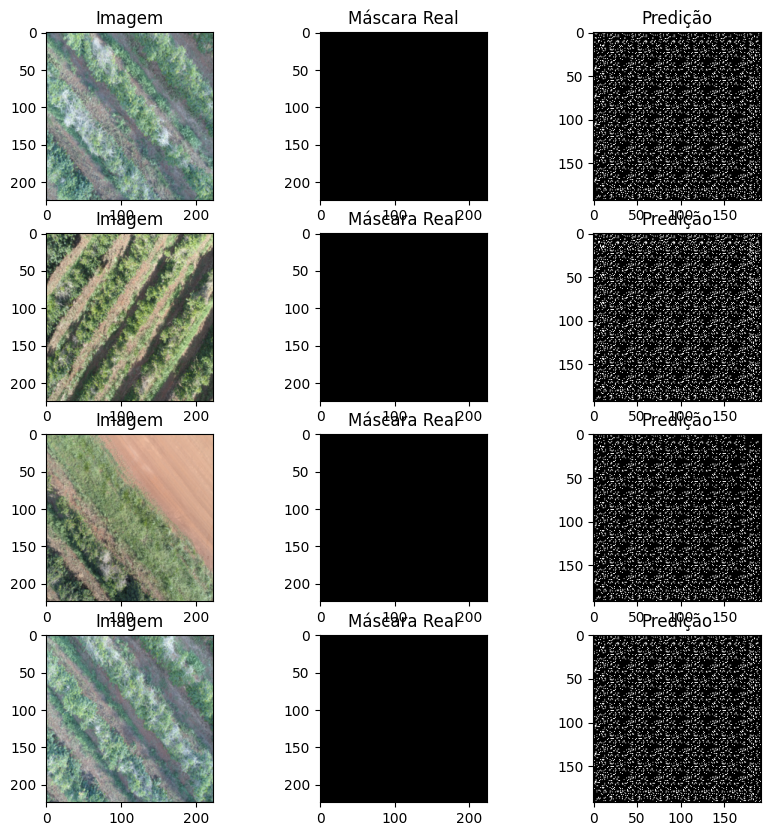

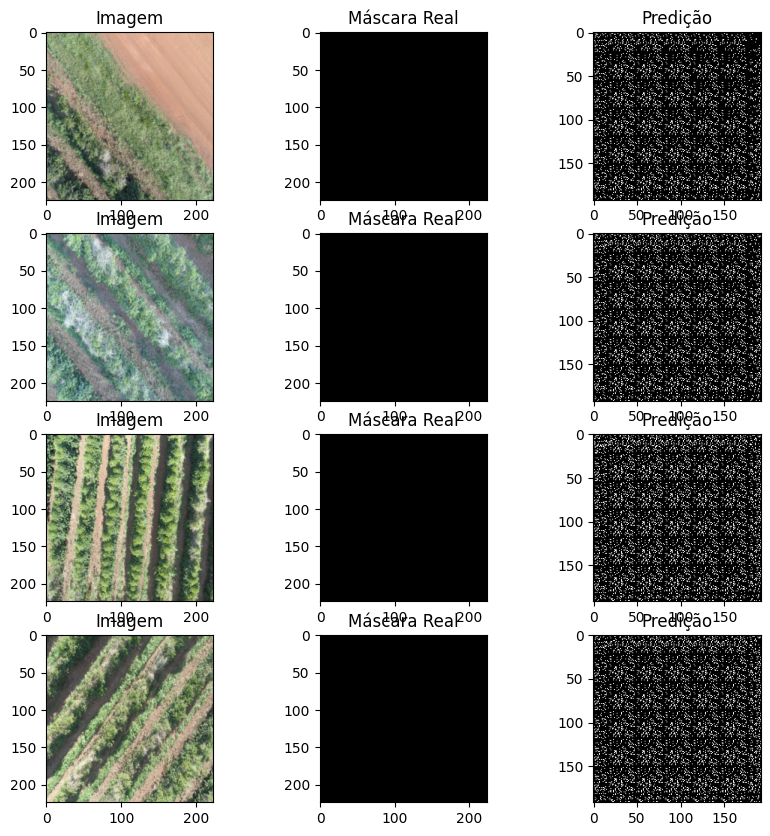

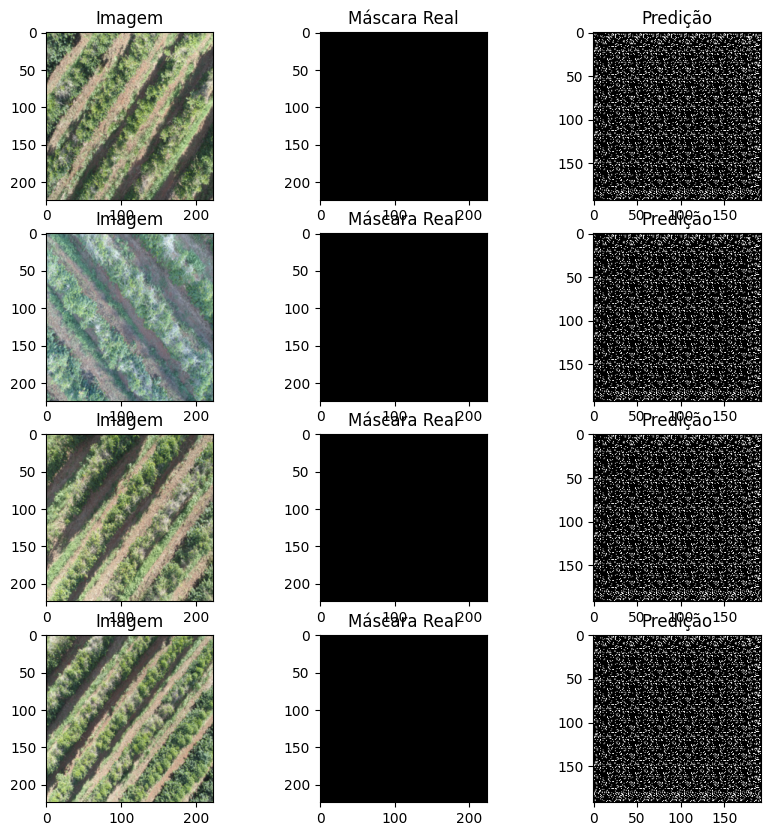

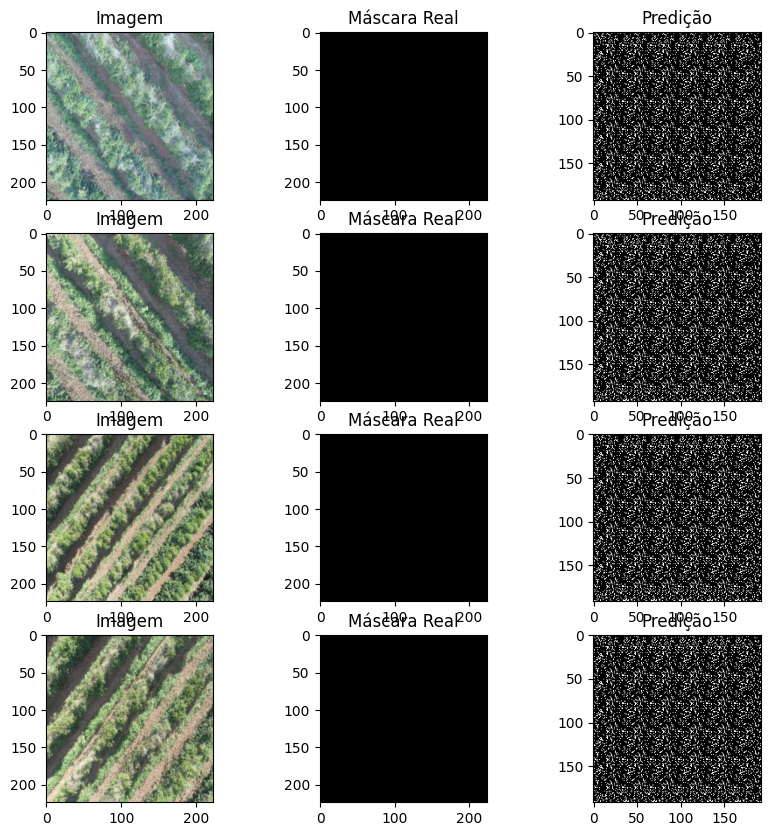

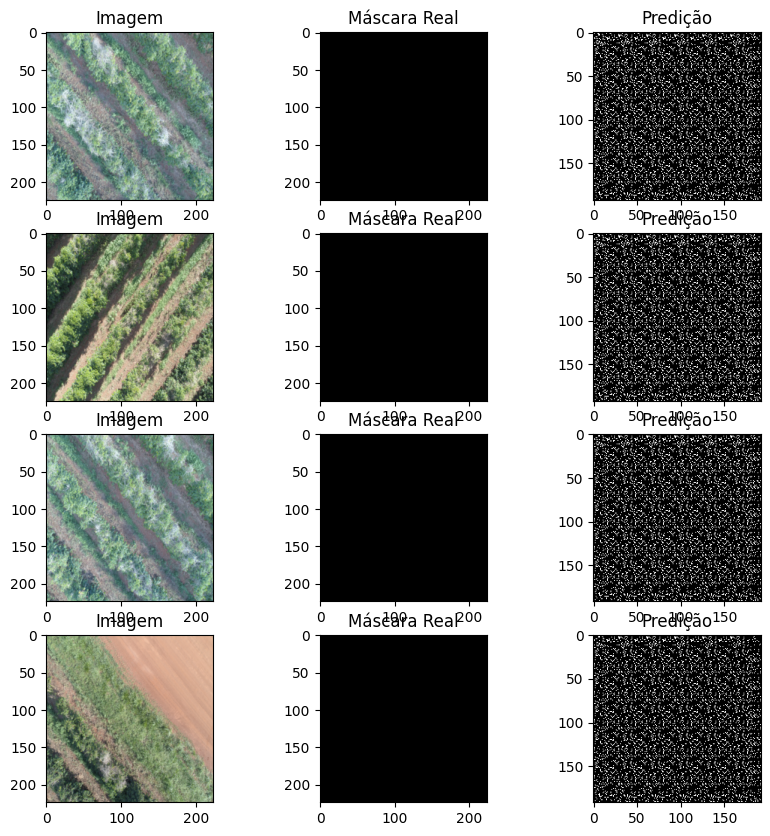

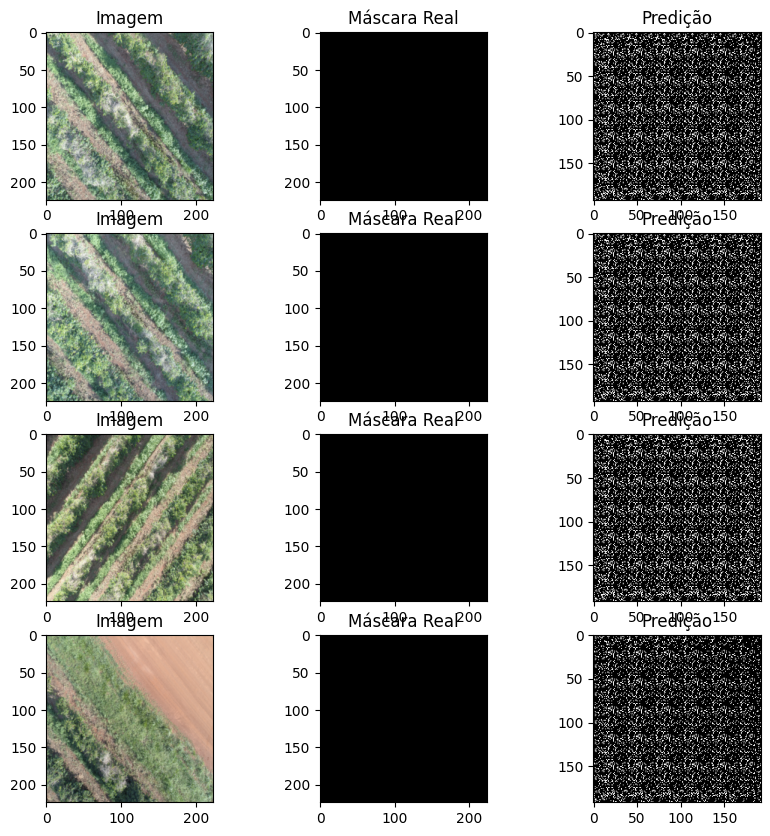

In [51]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Inicializar listas para armazenar a perda e a precisão
train_losses = []
train_accuracies = []
val_accuracies = []

# Exemplo de inicialização da rede:
model = AlexNetSegmentation(num_classes=1)  # Número de classes de saída

# Definindo a função de perda e o otimizador
criterion = nn.BCEWithLogitsLoss()  # Para segmentação binária; troque para CrossEntropyLoss para multi-classes
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Exemplo de uso
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

mask_transforms = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
])
    
# Carregar o dataset
train_dataset = SegmentationDataset(
    image_dir=img_folder_train + r"/images",
    mask_dir=img_folder_train_mask,
    transform=transform,
    mask_transform=mask_transform
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Definindo a função de perda e o otimizador
criterion = nn.BCEWithLogitsLoss()  # Para segmentação binária; troque para CrossEntropyLoss para multi-classes
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Função de Treinamento
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print('Epoch %d starting...' % (epoch+1))
        model.train()
        running_loss = 0.0
        
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # Zerar gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Redimensionar máscaras para corresponder ao tamanho das saídas do modelo
            masks = F.interpolate(masks, size=outputs.shape[2:], mode='nearest')

            # Calcular a perda
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

# Treinar o modelo
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

%matplotlib inline

# Função de Avaliação e Visualização de Resultados
def evaluate_and_visualize(model, dataloader, num_images=4):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()  # Binarização das previsões

            # Visualizar algumas imagens
            fig, ax = plt.subplots(num_images, 3, figsize=(10, 10))
            for i in range(num_images):
                ax[i, 0].imshow(images[i].cpu().permute(1, 2, 0))
                ax[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
                ax[i, 2].imshow(preds[i].cpu().squeeze(), cmap='gray')
                ax[i, 0].set_title("Imagem")
                ax[i, 1].set_title("Máscara Real")
                ax[i, 2].set_title("Predição")
            plt.ion()
            plt.show()
            break  # Mostrar apenas o primeiro lote para visualização

# Avaliar e Visualizar o Modelo
evaluate_and_visualize(model, train_loader)